In [1]:
# Librerias generales
import pandas as pd
import numpy as np
import json

# Time
import datetime as dt
from datetime import datetime, timedelta

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# OneHotEncoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

# Algoritmos
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Pipeline
from sklearn.pipeline import make_pipeline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [2]:
data = pd.read_csv('six_loan_id.csv').drop(['Unnamed: 0'], axis=1)
data.head()

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,2019-08-30,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,2019-09-17,5972929.73,5972929.73
2,241,25720,1076,10,2019-10-30,PAID,0,2019-10-30,5941645.15,5941645.15
3,241,25721,1076,11,2019-11-29,PAID,0,2019-11-29,5939653.40,5939653.40
4,241,25722,1076,12,2019-12-30,PAID,0,2019-12-30,5939653.40,5939653.40


In [3]:
# Cambiara formato datatime
data['paid_date']= pd.to_datetime(data['paid_date']) 
data['expected_date']= pd.to_datetime(data['expected_date']) 

In [4]:
# Aggregate data on a customer level
data = data.groupby(['client_id', 'loan_id']).agg({
    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'state': lambda x: x.iloc[-1], # Devuelve el último state
    'arrears_days':'mean',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
data.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
data.reset_index(inplace=True)
data.head()

,client_id,loan_id,recency,state,arrears_days,total_paid
0,241,1076,268.0,PAID,3.0,147915805.0
1,241,1244,268.0,PAID,4.0,91852726.0
2,362,1469,200.0,PAID,2.0,15211138.0
3,428,119,233.0,PAID,11.0,8713879.0
4,428,120,233.0,PAID,11.0,8102608.0


In [5]:
# Aggregate data on a customer level
#datamart = data.groupby(['client_id', 'loan_id']).agg({
#    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
 #   'state': lambda x: x.iloc[-1], # Devuelve el último state
  #  'arrears_days':'mean',
   # 'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
#datamart.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
#datamart.reset_index(inplace=True)

#### NOTA: La frecuencia no será tenida en cuenta para este proyecto porque todos los datos se filtró por los últimos 6 meses. Por lo tanto, la frecuencia es la misma para todos los clientes.

In [6]:
datamart = data.drop('state', axis=1)

In [7]:
datamart.head(8)

,client_id,loan_id,recency,arrears_days,total_paid
0,241,1076,268.0,3.0,147915805.0
1,241,1244,268.0,4.0,91852726.0
2,362,1469,200.0,2.0,15211138.0
3,428,119,233.0,11.0,8713879.0
4,428,120,233.0,11.0,8102608.0
5,429,998,589.0,11.0,34013973.0
6,429,1512,157.0,18.0,12358937.0
7,430,205,217.0,6.0,127943202.0


In [8]:
datamart['recency'].isnull().sum()

20

In [9]:
datamart['recency']

0      268.0
1      268.0
2      200.0
3      233.0
4      233.0
       ...  
577    210.0
578    214.0
579    199.0
580    192.0
581    214.0
Name: recency, Length: 582, dtype: float64

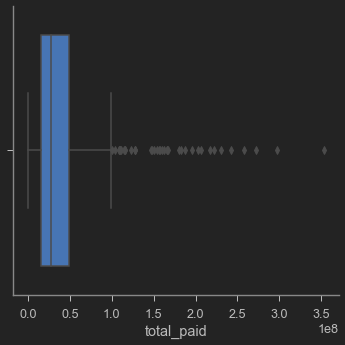

In [10]:
sns.catplot(x='total_paid', data=datamart, kind='box')
plt.show()

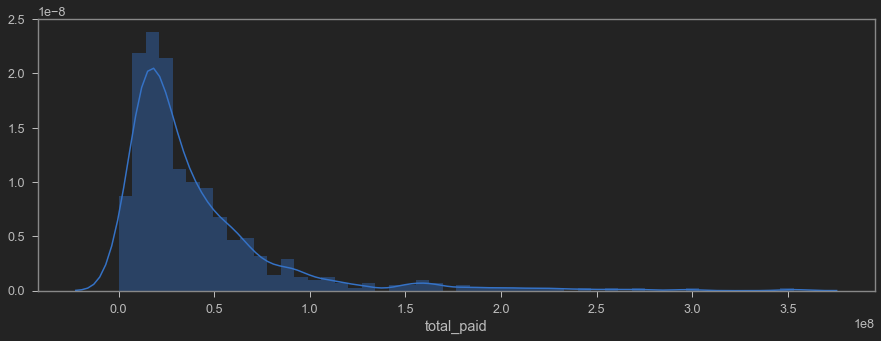

In [11]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.total_paid,kde=True,bins=50)
plt.show()

In [12]:
datamart.arrears_days.describe()

count    582.000000
mean      17.542955
std       42.601149
min        0.000000
25%        0.000000
50%        4.000000
75%       14.000000
max      354.000000
Name: arrears_days, dtype: float64

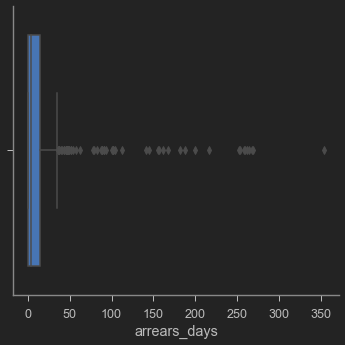

In [13]:
sns.catplot(x='arrears_days', data=datamart, kind='box')
plt.show()

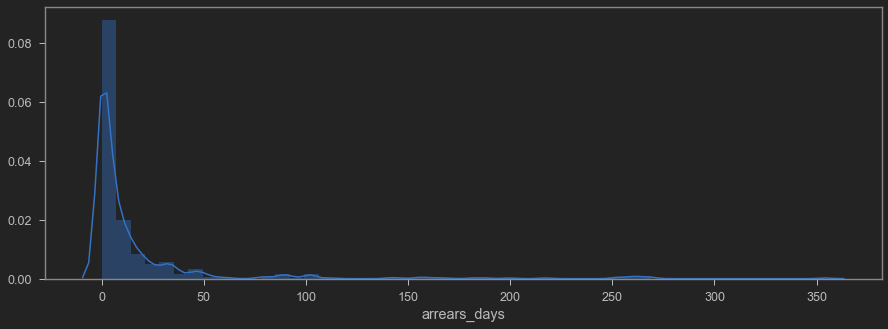

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.arrears_days,kde=True,bins=50)
plt.show()

### Construyendo segmento RFM

+ Para la antiguedad(recency) se le asigna el mayor percentil al cliente que ha usado recientemente los servicios. Menor valor al que lleva tiempo sin usarlos.
+ Para el caso de la frecuencia(medida por los dias de retraso) y el valor monetario. Entre mayor sea el valor estas variables asi mismo se le asignara los percentiles

In [15]:
datamart.describe()

,client_id,loan_id,recency,arrears_days,total_paid
count,582.000000,582.000000,562.000000,582.000000,5.820000e+02
mean,2650.249141,1016.900344,288.021352,17.542955,4.032477e+07
std,1617.810115,395.126743,162.956113,42.601149,4.338502e+07
min,241.000000,11.000000,24.000000,0.000000,0.000000e+00
25%,1465.250000,685.250000,196.000000,0.000000,1.517247e+07
50%,2440.500000,1118.500000,211.000000,4.000000,2.689099e+07
75%,3741.750000,1331.750000,339.250000,14.000000,4.915712e+07
max,7279.000000,1600.000000,976.000000,354.000000,3.531907e+08


In [16]:
# Create numbered labels
r_labels = range(4,0,-1)

#Crear nuevo dataframe con los percentiles
recency_quartiles = pd.qcut(datamart['recency'], q=4, labels=r_labels)
datamart = datamart.assign(R = recency_quartiles.values)
datamart['R'].fillna(4, inplace=True)
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R
0,241,1076,268.0,3.0,147915805.0,2
1,241,1244,268.0,4.0,91852726.0,2
2,362,1469,200.0,2.0,15211138.0,3
3,428,119,233.0,11.0,8713879.0,2
4,428,120,233.0,11.0,8102608.0,2
...,...,...,...,...,...,...
577,6734,1499,210.0,10.0,16038476.0,3
578,6982,1503,214.0,6.0,36277437.0,2
579,7008,1593,199.0,13.0,23829284.0,3
580,7145,1492,192.0,0.0,85184813.0,4


##### Total pagado

In [17]:
#f_quartiles = pd.qcut(datamart.arrears_days, q=4, labels=range(1,5))
t_quartiles = pd.qcut(datamart.total_paid, q=4, labels=range(1,5), precision=0)

# Agregar una nueva columna y asignar los valores
datamart = datamart.assign(T = t_quartiles.values)
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R,T
0,241,1076,268.0,3.0,147915805.0,2,4
1,241,1244,268.0,4.0,91852726.0,2,4
2,362,1469,200.0,2.0,15211138.0,3,2
3,428,119,233.0,11.0,8713879.0,2,1
4,428,120,233.0,11.0,8102608.0,2,1
...,...,...,...,...,...,...,...
577,6734,1499,210.0,10.0,16038476.0,3,2
578,6982,1503,214.0,6.0,36277437.0,2,3
579,7008,1593,199.0,13.0,23829284.0,3,2
580,7145,1492,192.0,0.0,85184813.0,4,4


##### Construcción de segmento RFM y RFM score
+ Concatenar los valores de los cuartiles
+ Sumar los valores de los cuartiles

In [18]:
def join_rm(x): return str(x['R']) + str(x['T'])

datamart['RFM_Segment'] = datamart.apply(join_rm, axis=1)
datamart['RFM_Score'] = datamart[['R','T']].sum(axis=1)

In [19]:
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R,T,RFM_Segment,RFM_Score
0,241,1076,268.0,3.0,147915805.0,2,4,24,6.0
1,241,1244,268.0,4.0,91852726.0,2,4,24,6.0
2,362,1469,200.0,2.0,15211138.0,3,2,32,5.0
3,428,119,233.0,11.0,8713879.0,2,1,21,3.0
4,428,120,233.0,11.0,8102608.0,2,1,21,3.0
...,...,...,...,...,...,...,...,...,...
577,6734,1499,210.0,10.0,16038476.0,3,2,32,5.0
578,6982,1503,214.0,6.0,36277437.0,2,3,23,5.0
579,7008,1593,199.0,13.0,23829284.0,3,2,32,5.0
580,7145,1492,192.0,0.0,85184813.0,4,4,44,8.0


In [20]:
datamart['RFM_Score'].value_counts()

5.0    166
6.0    124
4.0    116
3.0     66
7.0     64
8.0     29
2.0     17
Name: RFM_Score, dtype: int64

### Clusterización preeliminar aplicando percentiles de metricas RFM

In [21]:
def segment_me(df):
    if df['RFM_Score'] >= 7:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6):
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
    'recency': 'mean',
    'total_paid': ['mean', 'count']}).round(1)

recency  total_paid      
                   mean        mean count
General_Segment                          
Bronze            300.8  32196321.5   323
Gold              187.2  67024405.0    93
Silver            324.0  41182738.9   166

#### Centrando varibles con diferentes 'means'

In [22]:
# Copiar dataframe
datamart_rt = datamart

In [23]:
# Dejar solo las columnas que se necesitan
datamart_rt.drop(['R', 'T', 'RFM_Segment', 'General_Segment'], axis=1, inplace=True)

In [24]:
datamart_rt.head()

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score
0,241,1076,268.0,3.0,147915805.0,6.0
1,241,1244,268.0,4.0,91852726.0,6.0
2,362,1469,200.0,2.0,15211138.0,5.0
3,428,119,233.0,11.0,8713879.0,3.0
4,428,120,233.0,11.0,8102608.0,3.0


In [25]:
datamart_centered = datamart_rt - datamart_rt.mean()
datamart_centered.describe().round(2)

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score
count,582.00,582.00,562.00,582.00,5.820000e+02,582.00
mean,0.00,-0.00,-0.00,-0.00,-0.000000e+00,0.00
std,1617.81,395.13,162.96,42.60,4.338502e+07,1.42
min,-2409.25,-1005.90,-264.02,-17.54,-4.032477e+07,-3.07
25%,-1185.00,-331.65,-92.02,-17.54,-2.515230e+07,-1.07
50%,-209.75,101.60,-77.02,-13.54,-1.343378e+07,-0.07
75%,1091.50,314.85,51.23,-3.54,8.832348e+06,0.93
max,4628.75,583.10,687.98,336.46,3.128659e+08,2.93


In [26]:
datamart

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score
0,241,1076,268.0,3.0,147915805.0,6.0
1,241,1244,268.0,4.0,91852726.0,6.0
2,362,1469,200.0,2.0,15211138.0,5.0
3,428,119,233.0,11.0,8713879.0,3.0
4,428,120,233.0,11.0,8102608.0,3.0
...,...,...,...,...,...,...
577,6734,1499,210.0,10.0,16038476.0,5.0
578,6982,1503,214.0,6.0,36277437.0,5.0
579,7008,1593,199.0,13.0,23829284.0,5.0
580,7145,1492,192.0,0.0,85184813.0,8.0


In [27]:
#Reemplazar missing values por el promedio
datamart.fillna(datamart.mean(), inplace=True)

In [28]:
analysis = datamart.drop(['client_id', 'loan_id'], axis=1)
analysis.head()

,recency,arrears_days,total_paid,RFM_Score
0,268.0,3.0,147915805.0,6.0
1,268.0,4.0,91852726.0,6.0
2,200.0,2.0,15211138.0,5.0
3,233.0,11.0,8713879.0,3.0
4,233.0,11.0,8102608.0,3.0


In [29]:
corr_p = analysis.corr(method='pearson')
corr_p

,recency,arrears_days,total_paid,RFM_Score
recency,1.000000,0.011563,0.146384,-0.453107
arrears_days,0.011563,1.000000,-0.207955,-0.147477
total_paid,0.146384,-0.207955,1.000000,0.418917
RFM_Score,-0.453107,-0.147477,0.418917,1.000000


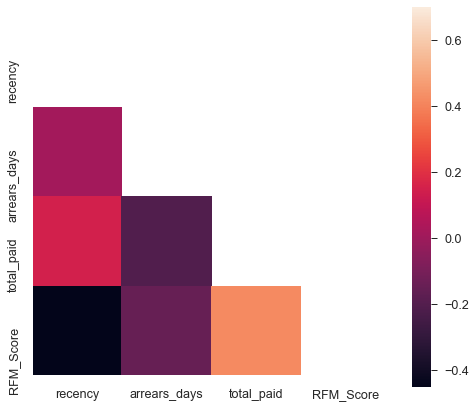

In [30]:
mask=np.zeros_like(corr_p,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):
    a=sns.heatmap(corr_p,mask=mask,vmax=0.7,square=True)

In [31]:
corr_s = analysis.corr(method='spearman')
corr_s

,recency,arrears_days,total_paid,RFM_Score
recency,1.000000,0.060315,0.134734,-0.616741
arrears_days,0.060315,1.000000,-0.254957,-0.175416
total_paid,0.134734,-0.254957,1.000000,0.567461
RFM_Score,-0.616741,-0.175416,0.567461,1.000000


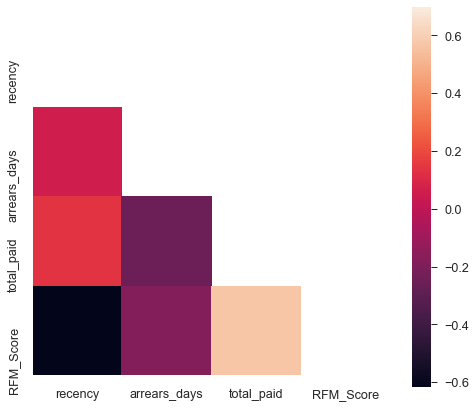

In [32]:
mask=np.zeros_like(corr_s,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style("white"):
    a=sns.heatmap(corr_s,mask=mask,vmax=0.7,square=True)

In [33]:
# Revisar los features mas importantes del conjunto de datos
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn import utils

X = analysis.drop('recency',axis=1)
Y = analysis['recency']

# Transformación variable Y
lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(Y)
#print(training_scores_encoded)

#print(utils.multiclass.type_of_target(Y))
#print(utils.multiclass.type_of_target(Y.astype('int')))
#print(utils.multiclass.type_of_target(training_scores_encoded))

clf = ExtraTreesClassifier()
clf = clf.fit(X, training_scores_encoded)
clf.feature_importances_

array([0.30503657, 0.62297822, 0.07198521])

In [34]:
# Implementación de features
new_data = analysis.copy()
new_data.drop('recency', axis=1)

# TODO: Split the data into training and testing sets using the given feature as the target

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(new_data, analysis['recency'], test_size = 0.2, random_state=1)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn import tree
regressor = tree.DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
from sklearn.metrics import accuracy_score
y_pred = regressor.predict(X_test)
#score = accuracy_score(y_test, y_pred)
#print ("The accuracy score is {}.".format(score))

In [35]:
score = regressor.score(X_test, y_test)
print ("The accuracy score is {}.".format(score))

The accuracy score is 0.9862825543710859.


In [36]:
#datamart_rt.set_index('client_id', inplace=True)

In [37]:
#datamart_rt

Como se puede observar las desviaciones estandar no se encuentran en un mismo rango. Por lo que se hace necesario re escalar los datos. Se utilizará StandardScaler

### Rescalamiento de los datos 

In [38]:
def reescalamiento(df):
    """Esta función reescala los datos financieros"""
    # Set index
    df.set_index(['client_id', 'loan_id'], inplace=True)
    # Los valores nulos se reemplazan por el promedio de los valores
    df.fillna(df.mean(), inplace=True)

    # Reescalar los datos
    scaler = StandardScaler()
    #scaler.fit(df)
    datamart_scaler = scaler.fit_transform(df)
    
    datamart_normalized = normalize(datamart_scaler)

    # Create a pandas DataFrame
    data_normalized_pandas = pd.DataFrame(
        datamart_normalized, index=df.index, columns=df.columns)

    data_normalized_pandas.reset_index(['client_id', 'loan_id'], inplace=True)

    return data_normalized_pandas

In [39]:
normalizada_fin = reescalamiento(datamart_rt)

In [40]:
normalizada_fin.head()

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score
0,241,1076,-0.048261,-0.131763,0.957192,0.253164
1,241,1244,-0.089367,-0.227217,0.848889,0.468800
2,362,1469,-0.625344,-0.415057,-0.658514,-0.055067
3,428,119,-0.205514,-0.091860,-0.435784,-0.871446
4,428,120,-0.204756,-0.091521,-0.442573,-0.868233


In [41]:
normalizada_fin.isnull().sum()

client_id       0
loan_id         0
recency         0
arrears_days    0
total_paid      0
RFM_Score       0
dtype: int64

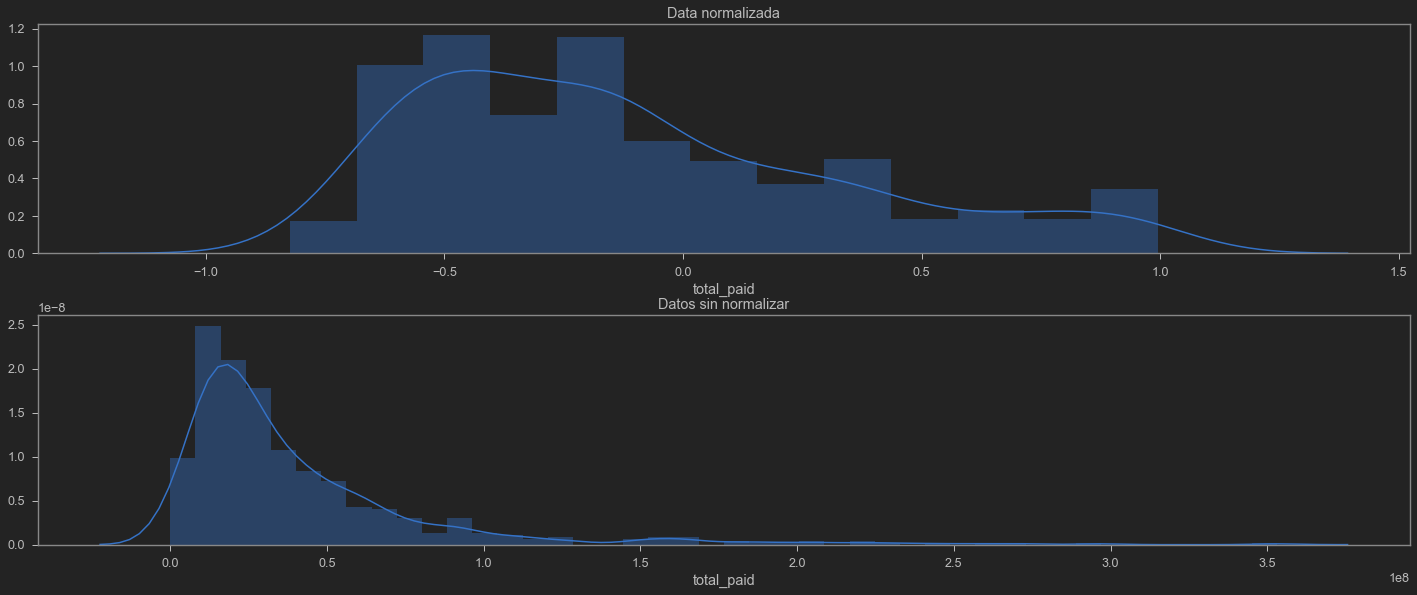

In [42]:
plt.figure(figsize=(20, 20)) # medidas del grafico 


plt.subplot(5,1,1)
plt.tight_layout()
plt.title("Data normalizada")

sns.distplot(normalizada_fin.total_paid)



plt.subplot(5,1,2)
plt.tight_layout()
plt.title("Datos sin normalizar")
sns.distplot(datamart.total_paid)
plt.show()

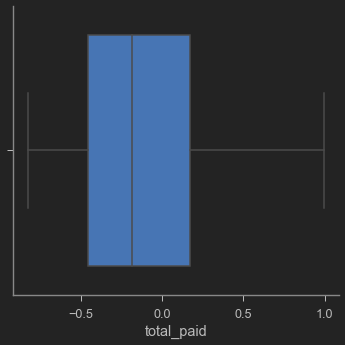

In [43]:

sns.catplot(x='total_paid', data=normalizada_fin, kind='box')
plt.show()

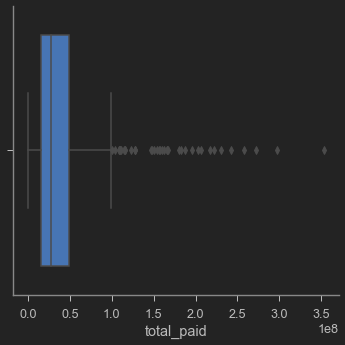

In [44]:
sns.catplot(x='total_paid', data=datamart, kind='box')
plt.show()

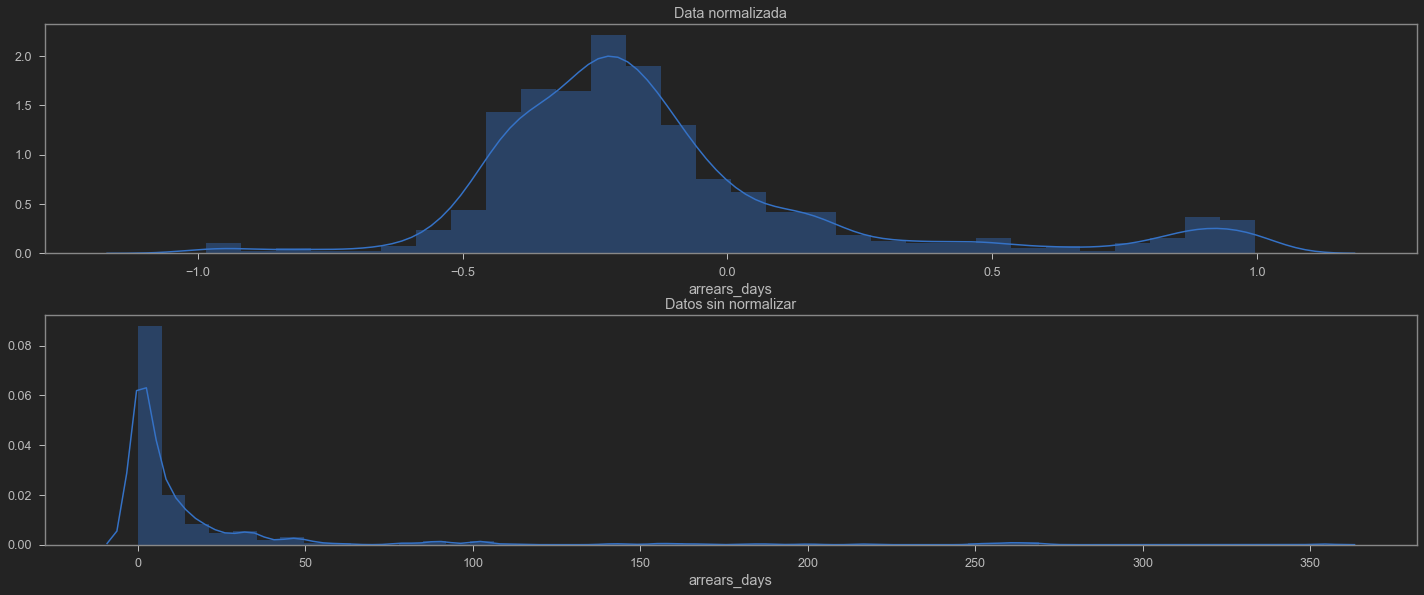

In [45]:
plt.figure(figsize=(20, 20)) # medidas del grafico 


plt.subplot(5,1,1)
plt.tight_layout()
plt.title("Data normalizada")

sns.distplot(normalizada_fin.arrears_days)



plt.subplot(5,1,2)
plt.tight_layout()
plt.title("Datos sin normalizar")
sns.distplot(datamart.arrears_days)
plt.show()

#### AQUI SE HACE EL MERGE CON LA OTRA DATA

* Merge a los dataframe --> 'data_normalized_pandas' y los datos que hay en matriz cliente

In [46]:
normalizada_fin.columns

Index(['client_id', 'loan_id', 'recency', 'arrears_days', 'total_paid', 'RFM_Score'], dtype='object')

In [47]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']

cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']
cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
normalizada = pd.DataFrame()
normalizada_fin= pd.merge(normalizada_fin,data[['loan_id','state']],on='loan_id', how='left')
normalizada_fin.head(8)

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score,state
0,241,1076,-0.048261,-0.131763,0.957192,0.253164,PAID
1,241,1244,-0.089367,-0.227217,0.848889,0.468800,PAID
2,362,1469,-0.625344,-0.415057,-0.658514,-0.055067,PAID
3,428,119,-0.205514,-0.091860,-0.435784,-0.871446,PAID
4,428,120,-0.204756,-0.091521,-0.442573,-0.868233,PAID
5,429,998,0.923304,-0.075444,-0.071453,-0.369746,PAID
6,429,1512,-0.784638,0.010288,-0.618129,-0.046419,LATE
7,430,205,-0.202889,-0.123945,0.923825,0.300036,PAID


In [58]:
data_transform = normalizada_fin.merge(cat_data, left_on='client_id', right_on='ID Cliente').drop('ID Cliente', axis=1)
data_transform.head(6)

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score,state,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,1076,-0.048261,-0.131763,0.957192,0.253164,PAID,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,1244,-0.089367,-0.227217,0.848889,0.468800,PAID,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
2,362,1469,-0.625344,-0.415057,-0.658514,-0.055067,PAID,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0
3,428,119,-0.205514,-0.091860,-0.435784,-0.871446,PAID,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
4,428,120,-0.204756,-0.091521,-0.442573,-0.868233,PAID,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
5,429,998,0.923304,-0.075444,-0.071453,-0.369746,PAID,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2


In [60]:
# Se elimina sin INFO de huellas de consulta y score bureau
#normalizada.replace('SIN INFO', np.nan)
data_transform = data_transform[data_transform['Score Bureau Empresa'] != "SIN INFO"]
data_transform = data_transform[data_transform['Huellas de Consulta'] != "SIN INFO"]
#normalizada = normalizada.dropna(how='all', axis=1)
data_transform.shape

(580, 30)

In [61]:
data_transform.columns

Index(['client_id', 'loan_id', 'recency', 'arrears_days', 'total_paid', 'RFM_Score', 'state', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

### OneHotEncoding
* Agregar columnas
Activador 'Score Bureau Empresa', 'Huellas de Consulta'

In [62]:
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                'Procesos judiciales', 'Alertas', 
                'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Activador',
                'Impacto', 'Acceso previso a la banca', 'Mujeres empresarias']

In [63]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

In [64]:
normalizada = column_trans.fit_transform(data_transform)
#print(data_transform)
print(column_trans.fit_transform(data_transform).tolist())

[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 241, 1076, -0.048260558440372296, -0.13176325530118493, 0.9571923683127865, 0.2531642413438694, 250000000, 5, 925, 8, 45, 2, 16, 2], [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 241, 1244, -0.0893670296540289, -0.2272166078780165, 0.8488892566400793, 0.4687997195778569, 250000000, 5, 925, 8, 45, 2, 16, 2], [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [65]:
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['state', 'Uso de los recursos', 'Plazo',
                                  'Sector', 'Ingresos', 'Ubicación',
                                  'Procesos judiciales', 'Alertas',
                                  'Website empresa', 'Instagram empresa',
                                  'LinkedIn empresa', 'LinkedIn empresarios',
                                  'Activador', 'Impacto',
                                  'Acceso previso a la banca',
                                  'Mujeres empresarias'])])

In [66]:
#clean.shape

In [67]:
# Imprimir cada columna del dataset clasificada por onehotencoder y los que no pasaron por el proceso de transformación
column_trans.get_feature_names()

['onehotencoder__x0_LATE',
 'onehotencoder__x0_PAID',
 'onehotencoder__x0_PARTIALLY_PAID',
 'onehotencoder__x1_CR ',
 'onehotencoder__x1_KT - CO',
 'onehotencoder__x1_KT - EX',
 'onehotencoder__x1_SP',
 'onehotencoder__x2_13 a 24 meses',
 'onehotencoder__x2_25 a 36 meses',
 'onehotencoder__x2_Menos de 12 meses',
 'onehotencoder__x2_Más de 37 meses',
 'onehotencoder__x3_Comercio',
 'onehotencoder__x3_Industria',
 'onehotencoder__x3_Servicios',
 'onehotencoder__x4_Growth',
 'onehotencoder__x4_Scale Up',
 'onehotencoder__x4_Seed',
 'onehotencoder__x4_Venture',
 'onehotencoder__x5_Armenia',
 'onehotencoder__x5_Barranquilla',
 'onehotencoder__x5_Bello',
 'onehotencoder__x5_Bogotá D.C.',
 'onehotencoder__x5_Bucaramanga',
 'onehotencoder__x5_Cali',
 'onehotencoder__x5_Cartagena de indias',
 'onehotencoder__x5_Copacabana',
 'onehotencoder__x5_Envigado',
 'onehotencoder__x5_Itagüí',
 'onehotencoder__x5_La Ceja',
 'onehotencoder__x5_La Estrella',
 'onehotencoder__x5_Manizales',
 'onehotencoder__

#### Significado de OneHotEncoding
* state 

1 0 0--> Late

0 1 0--> PAID. 

0 0 1--> PARTIALLY_PAID

* Recursos 


1 0 0 0 --> CR

0 1 0 0 --> KT - CO

0 0 1 0--> KT - EX

0 0 0 1 --> SP

* Plazo

1 0 0 0 --> 13 a 24 meses

0 1 0 0 --> 25 a 36 meses

0 0 1 0--> Menos de 12 meses

0 0 0 1 --> Más de 37 meses

In [68]:
normalizada

array([[0.0, 1.0, 0.0, ..., 2, 16, 2],
       [0.0, 1.0, 0.0, ..., 2, 16, 2],
       [0.0, 1.0, 0.0, ..., 3, 3, 0],
       ...,
       [1.0, 0.0, 0.0, ..., 3, 14, 5],
       [0.0, 1.0, 0.0, ..., 2, 12, 9],
       [1.0, 0.0, 0.0, ..., 2, 6, 0]], dtype=object)

In [69]:
normalizada.isnull().sum()

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

#### K means
K optimizado : eblow method

In [70]:
kmeans = KMeans(n_clusters=6, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(normalizada)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [71]:
# Fit KMeans and calculate SSE for each *k*
#sse = {}
#for k in range(1,11):
#    kmeans = KMeans(n_clusters=k, random_state=1)
#    kmeans.fit(data_transform)
#    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
#score_cluster = pd.DataFrame({'Cluster':range(1,11), 'Score':sse})
#plt.figure(figsize=(8,5))
# Plot SSE for each *k*
#plt.title('The Elbow Method')
#plt.xlabel('k'); plt.ylabel('SSE')
#sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
#plt.show()

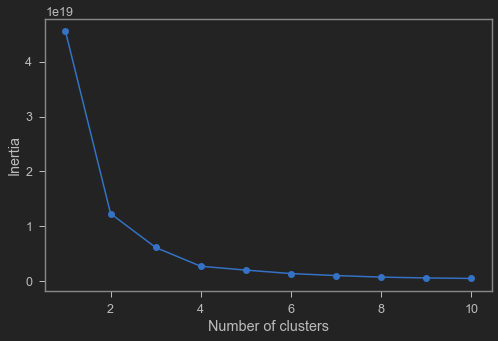

In [73]:
scores = []
# Set index
#normalizada.set_index(['client_id', 'loan_id'], inplace=True)
# Los valores nulos se reemplazan por el promedio de los valores
#normalizada.fillna(normalizada.mean(), inplace=True)

for k in range(1,11):
    km = KMeans(n_clusters=k,random_state=1)
    km = km.fit(normalizada)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [74]:
dfk

,Cluster,Score
0,1,4.555089e+19
1,2,1.228410e+19
2,3,6.094796e+18
3,4,2.667274e+18
4,5,1.965945e+18
5,6,1.336640e+18
6,7,9.704214e+17
7,8,6.883609e+17
8,9,5.368851e+17
9,10,4.446203e+17


#### Valor de la silueta 
El valor de la silueta mide cuán similar es un punto a su propio cluster (cohesión) en comparación con otros cluster (separación).

In [75]:
for i in range(2,17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(normalizada)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(normalizada,kmeans_labels, metric='euclidean').round(3)))

Silhouette score for 2 clusters k-means : 0.724 
Silhouette score for 3 clusters k-means : 0.639 
Silhouette score for 4 clusters k-means : 0.649 
Silhouette score for 5 clusters k-means : 0.639 
Silhouette score for 6 clusters k-means : 0.58 
Silhouette score for 7 clusters k-means : 0.584 
Silhouette score for 8 clusters k-means : 0.587 
Silhouette score for 9 clusters k-means : 0.6 
Silhouette score for 10 clusters k-means : 0.604 
Silhouette score for 11 clusters k-means : 0.632 
Silhouette score for 12 clusters k-means : 0.635 
Silhouette score for 13 clusters k-means : 0.632 
Silhouette score for 14 clusters k-means : 0.633 
Silhouette score for 15 clusters k-means : 0.658 
Silhouette score for 16 clusters k-means : 0.667 


#### Métrica de Davies Bouldin
Medida de similitud promedio de cada cluster con su cluster más similar, donde la similitud es la relación entre las distancias dentro del cluster y las distancias entre los clusters. La puntuación mínima es cero, y los valores más bajos indican una mejor agrupación.

In [76]:
for i in range(2, 17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(normalizada)
    print(f'Davies Bouldin Score {i}: {metrics.davies_bouldin_score(normalizada,kmeans_labels).round(3)}')

Davies Bouldin Score 2: 0.5
Davies Bouldin Score 3: 0.5
Davies Bouldin Score 4: 0.426
Davies Bouldin Score 5: 0.486
Davies Bouldin Score 6: 0.516
Davies Bouldin Score 7: 0.501
Davies Bouldin Score 8: 0.474
Davies Bouldin Score 9: 0.456
Davies Bouldin Score 10: 0.465
Davies Bouldin Score 11: 0.422
Davies Bouldin Score 12: 0.408
Davies Bouldin Score 13: 0.424
Davies Bouldin Score 14: 0.425
Davies Bouldin Score 15: 0.405
Davies Bouldin Score 16: 0.388


In [107]:
kmeans_labels=KMeans(n_clusters=4,random_state=1).fit_predict(normalizada)

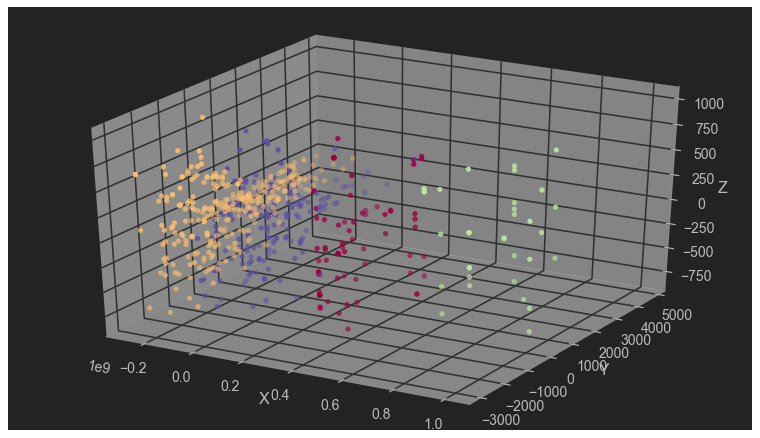

In [108]:
pca = PCA(n_components=3).fit_transform(normalizada)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### MiniBatch K-Means

In [79]:
for i in range(2,11):
    minikm_labels = MiniBatchKMeans(n_clusters=i,init='random',batch_size=100000).fit_predict(normalizada)
    print("Silhouette score for {} clusters MiniBatch k-means : {}".format(i,metrics.silhouette_score(normalizada, minikm_labels, metric='euclidean').round(3)))

Silhouette score for 2 clusters MiniBatch k-means : 0.724
Silhouette score for 3 clusters MiniBatch k-means : 0.607
Silhouette score for 4 clusters MiniBatch k-means : 0.647
Silhouette score for 5 clusters MiniBatch k-means : 0.635
Silhouette score for 6 clusters MiniBatch k-means : 0.566
Silhouette score for 7 clusters MiniBatch k-means : 0.591
Silhouette score for 8 clusters MiniBatch k-means : 0.56
Silhouette score for 9 clusters MiniBatch k-means : 0.594
Silhouette score for 10 clusters MiniBatch k-means : 0.631


In [80]:
for i in range(2,11):
    minikm_labels = MiniBatchKMeans(n_clusters=i,init='random',batch_size=100000).fit_predict(normalizada)
    print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(normalizada,minikm_labels).round(3)))

Davies Bouldin Score:0.5
Davies Bouldin Score:0.529
Davies Bouldin Score:0.433
Davies Bouldin Score:0.497
Davies Bouldin Score:0.483
Davies Bouldin Score:0.481
Davies Bouldin Score:0.488
Davies Bouldin Score:0.55
Davies Bouldin Score:0.47


In [109]:
minikm_labels = MiniBatchKMeans(n_clusters=4,init='random',batch_size=100000).fit_predict(normalizada)

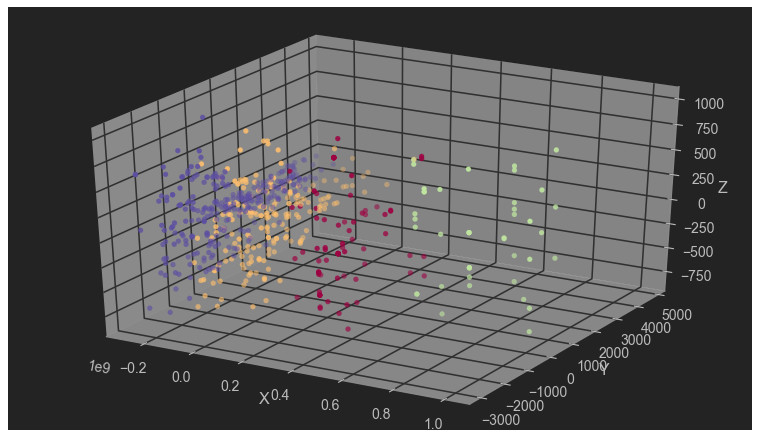

In [110]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=minikm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Hierarchical Clustering

El eje x contiene las muestras y el eje y representa la distancia entre estas muestras.

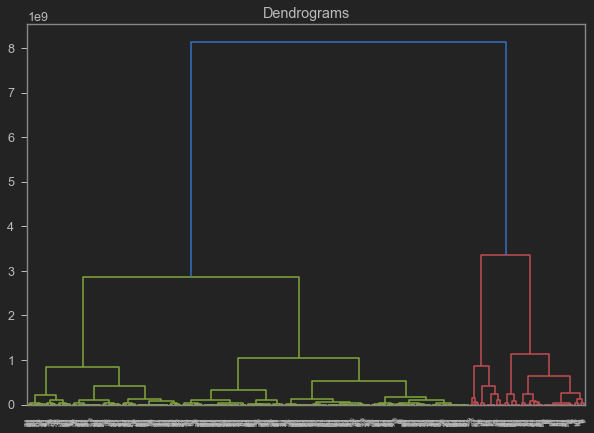

In [83]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(normalizada, method='ward'))

Hay dos grupos de acuerdo con el dendograma. Y el umbral de corte es 3

In [113]:
hcluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
hcp=hcluster.fit_predict(normalizada)
print('Silhouette Score for Hieararchial Clustering:'+str(metrics.silhouette_score(normalizada,hcp,metric='euclidean')))
print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(normalizada,hcp)))

Silhouette Score for Hieararchial Clustering:0.6805371018993925
Davies Bouldin Score:0.38695524231517386


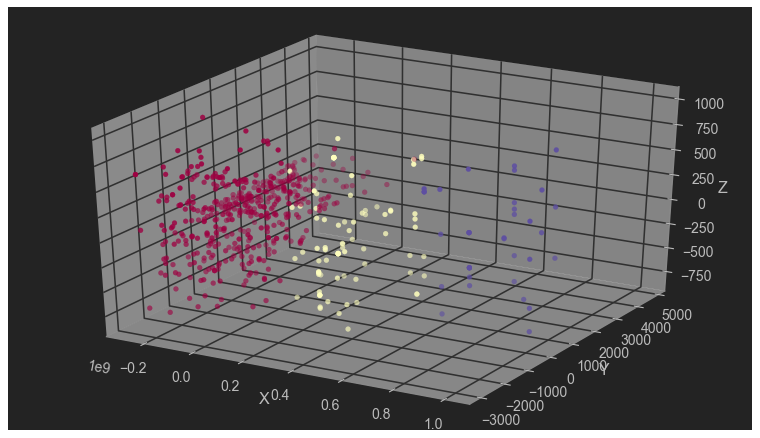

In [114]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=hcp,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Algoritmo DBSCAN

Agrupación basado en la densidad. La densidad se refiere a la proximidad de los puntos de datos en un cluster y es buena para los datos que contienen cluster de densidad similar.

In [86]:
#  Construyendo el modelo con valores de épsilon y número natural de minPuntos.
results = pd.DataFrame(
    columns=['Eps', 'Min_Samples', 'Number of Cluster', 'Silhouette Score'])
for i in range(2, 12):
    for j in range(2, 12):
        dbscan_cluster = DBSCAN(eps=i*0.2, min_samples=j)
        clusters = dbscan_cluster.fit_predict(normalizada)
        if len(np.unique(clusters)) > 2:
            results = results.append({'Eps': i*0.2,
                                      'Min_Samples': j,
                                      'Number of Cluster': len(np.unique(clusters)),
                                      'Silhouette Score': metrics.silhouette_score(normalizada, clusters),
                                      'Davies Bouldin Score': metrics.davies_bouldin_score(normalizada, clusters)}, ignore_index=True)

In [87]:
results.sort_values('Silhouette Score',ascending=False)[:5]

,Eps,Min_Samples,Number of Cluster,Silhouette Score,Davies Bouldin Score
11,2.2,3.0,6.0,0.279456,0.488758
5,1.6,3.0,4.0,0.276787,0.645735
7,1.8,3.0,4.0,0.276787,0.645735
9,2.0,3.0,4.0,0.276787,0.645735
12,2.2,4.0,4.0,0.268737,0.650324


In [115]:
dbscan_cluster = DBSCAN(eps=2.2, min_samples=3)
db_clusters=dbscan_cluster.fit_predict(normalizada)

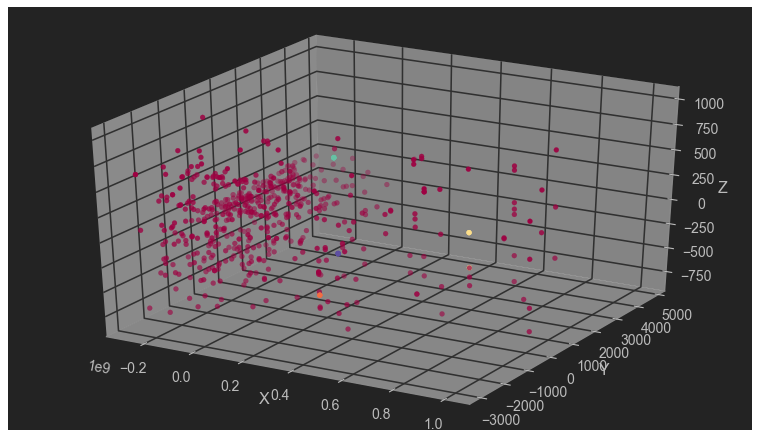

In [116]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=db_clusters,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Algoritmo GMM

Los Modelos de Mezcla Gaussiana (GMM) asumen que existen varias distribuciones Gaussianas, y cada una de ellas representa un cluster. Por lo tanto, un Modelo de Mezcla Gaussiana tiende a agrupar los puntos de datos que pertenecen a una única distribución.

<br>

**Determinar:**
+ n_conglomerados. 
+ El número óptimo de cluster (k) es el valor que minimiza el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC).



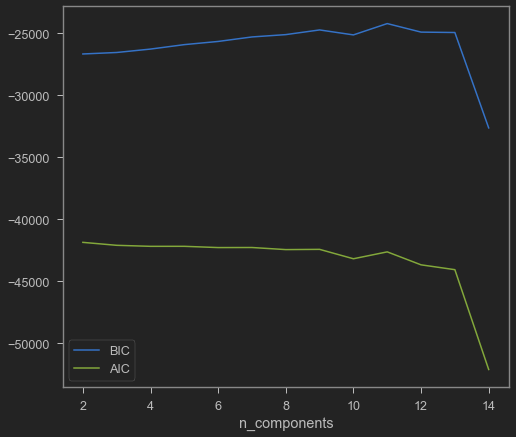

In [90]:
# Determinar: n_conglomerados. 
# El número óptimo de cluster (k) es el valor que minimiza el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC).

models = [GaussianMixture(n,covariance_type='tied', random_state=1).fit(normalizada) for n in range(2,15)]
plt.plot(range(2,15), [m.bic(normalizada) for m in models], label='BIC')
plt.plot(range(2,15), [m.aic(normalizada) for m in models], label='AIC')
plt.legend()
plt.xlabel('n_components')
plt.show()

In [91]:
parameters = ['full', 'tied', 'diag', 'spherical']
n_clusters = np.arange(1, 21)
results_ = pd.DataFrame(columns=[
                        'Covariance Type', 'Number of Cluster', 'Silhouette Score', 'Davies Bouldin Score'])
for i in parameters:
    for j in n_clusters:
        gmm_cluster = GaussianMixture(
            n_components=j, covariance_type=i, random_state=123)
        clusters = gmm_cluster.fit_predict(normalizada)
        if len(np.unique(clusters)) >= 2:
            results_ = results_.append({"Covariance Type": i, 'Number of Cluster': j, "Silhouette Score": metrics.silhouette_score(normalizada, clusters),
                                        'Davies Bouldin Score': metrics.davies_bouldin_score(normalizada, clusters)}, ignore_index=True)

In [92]:
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:5])

,Covariance Type,Number of Cluster,Silhouette Score,Davies Bouldin Score
0,full,2,0.723816,0.500021
19,tied,2,0.671221,0.571563
74,spherical,19,0.662676,0.372866
75,spherical,20,0.661683,0.374015
18,full,20,0.660049,0.364957


In [118]:
gmm_cluster=GaussianMixture(n_components=20,covariance_type="full",random_state=1)
gmm_cluster.fit(normalizada)
gmm_labels = gmm_cluster.predict(normalizada)

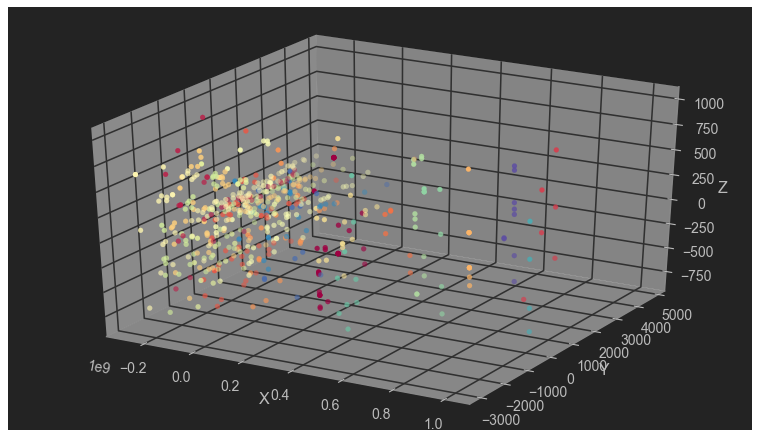

In [119]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=gmm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### MeanShift

Asigna los puntos de datos a los clusters de forma iterativa desplazando los puntos hacia la mayor densidad de puntos de datos, es decir, el centroide del cluster.


In [95]:
est_bandwidth = estimate_bandwidth(normalizada,quantile=0.1,n_samples=10000)
mean_shift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True).fit(normalizada)
labels_unique=np.unique(mean_shift.labels_)
n_clusters_=len(labels_unique)
print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 10


In [96]:
print('Silhouette Score for MeanShift:'+str(metrics.silhouette_score(normalizada,mean_shift.labels_,metric='euclidean').round(3)))
print('Davies Bouldin Score for MeanShift:'+str(metrics.davies_bouldin_score(normalizada,mean_shift.labels_).round(3)))

Silhouette Score for MeanShift:0.559
Davies Bouldin Score for MeanShift:0.452


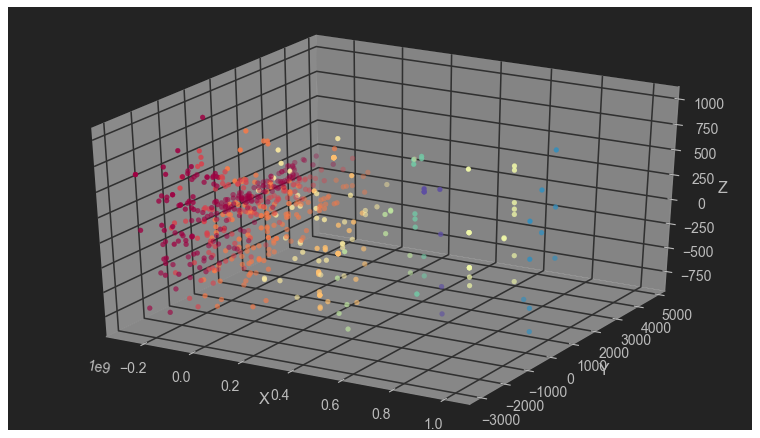

In [97]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=mean_shift.labels_, cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

### Comparison of Results 

In [122]:
algorithms=["K-Means","MiniBatch K-Means","Hierarchical Clustering","DBSCAN","Gaussian Mixture Model","MeanShift"]

# Silhouette Score
ss=[metrics.silhouette_score(normalizada,kmeans_labels),metrics.silhouette_score(normalizada,minikm_labels),metrics.silhouette_score(normalizada,hcp),
   metrics.silhouette_score(normalizada,db_clusters),metrics.silhouette_score(normalizada,gmm_labels),metrics.silhouette_score(normalizada,mean_shift.labels_)]

# Davies Bouldin Score
db=[metrics.davies_bouldin_score(normalizada,kmeans_labels),metrics.davies_bouldin_score(normalizada,minikm_labels),metrics.davies_bouldin_score(normalizada,hcp),
   metrics.davies_bouldin_score(normalizada,db_clusters),metrics.davies_bouldin_score(normalizada,gmm_labels),metrics.davies_bouldin_score(normalizada,mean_shift.labels_)]

In [123]:
comprsn={"Algorithms":algorithms,"Davies Bouldin":db,"Silhouette Score":ss}
compdf=pd.DataFrame(comprsn)
display(compdf.sort_values(by=["Silhouette Score"], ascending=False))

,Algorithms,Davies Bouldin,Silhouette Score
2,Hierarchical Clustering,0.386955,0.680537
4,Gaussian Mixture Model,0.370772,0.660043
0,K-Means,0.425893,0.649394
1,MiniBatch K-Means,0.433094,0.642829
5,MeanShift,0.452094,0.559173
3,DBSCAN,0.488758,0.279456


**Hierarchical Clustering** tiene mayor puntuación tanto en el Silhouete score como en Davies Bouldin

In [124]:
normalizada['Clusters']=list(hcp)
customers=pd.DataFrame(normalizada['Clusters'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers.T

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [125]:
means=pd.DataFrame(normalizada.describe().loc['mean'])
means.T.iloc[:,[0,1,2,3]].round(1)

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [ ]:
normalizada.set_index('Clusters')
grouped=normalizada.groupby(by='Clusters').mean().round(1)
grouped.iloc[:,[0,1,2,3]]

In [ ]:
normalizada.columns

In [ ]:
features=['recency', 'arrears_days', 'total_paid', 'RFM_Score']
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.barplot(grouped.index,grouped[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

#### NOTA:
* Probar con otros normalizadores. PowerTransformer()